In [1]:
import sys
import random
import logging
import config
import numpy as np
import matplotlib.pyplot as plt

In [22]:
data = np.load(open("simulation_outcome.train.npy", 'rb'))[()]

In [23]:
'''
Check shapes of the data.
'''
print("Keys: ",', '.join([key for key in data.keys()]), "\n")
for key in data.keys():
    if type(data[key]) is np.ndarray: 
        print("Shape %-11s %s" % (key, str(data[key].shape)))

Keys:  z, param, x, centroids_z, mu, centroids_x, s, t, y 

Shape z           (5000, 50, 1)
Shape x           (5000, 3024, 1)
Shape centroids_z (4, 50)
Shape mu          (5000, 4, 1)
Shape centroids_x (4, 3024)
Shape s           (5000, 4, 1)
Shape t           (5000, 1)
Shape y           (5000, 4, 1)


In [24]:
'''
Load data into variables for nicer access.
'''
z = data['z']
c = data['centroids_z']
s = data['s']
t = data['t'][:,0]
n_treatments = c.shape[0]
n_samples = z.shape[0]

for i in range(3):
    print("Nr t=%d: %d" % (i, sum(t==i)))
    

Nr t=0: 1225
Nr t=1: 1339
Nr t=2: 1270


In [25]:
'''
Dot product to centroid in topic space. 
Used for treatment assignment and outcome calculation.
'''
dist = np.zeros([n_treatments, n_samples])
for i in range(n_treatments):
    dist[i] = [np.dot(c[i],j) for j in z]

Min treatment param: [0.34539529]
Max treatment param: [1.]


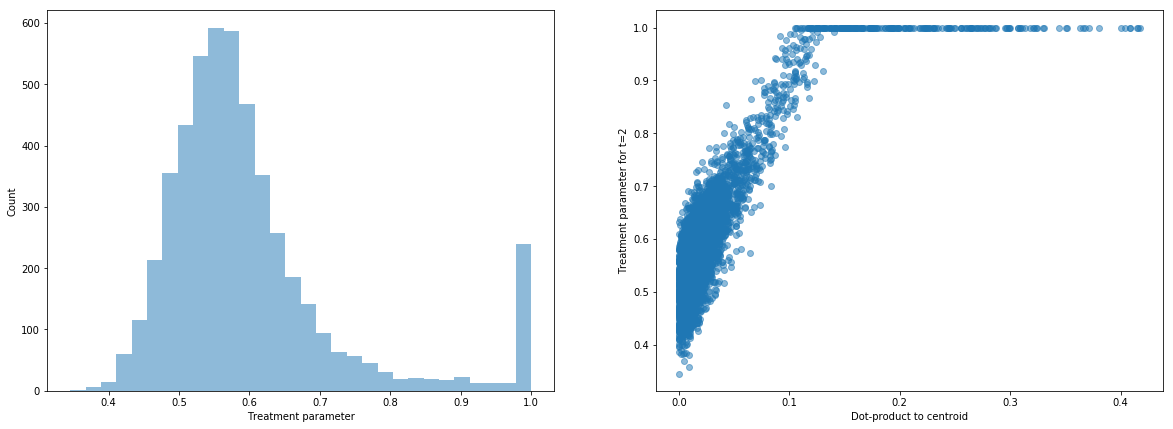

Treatment 0


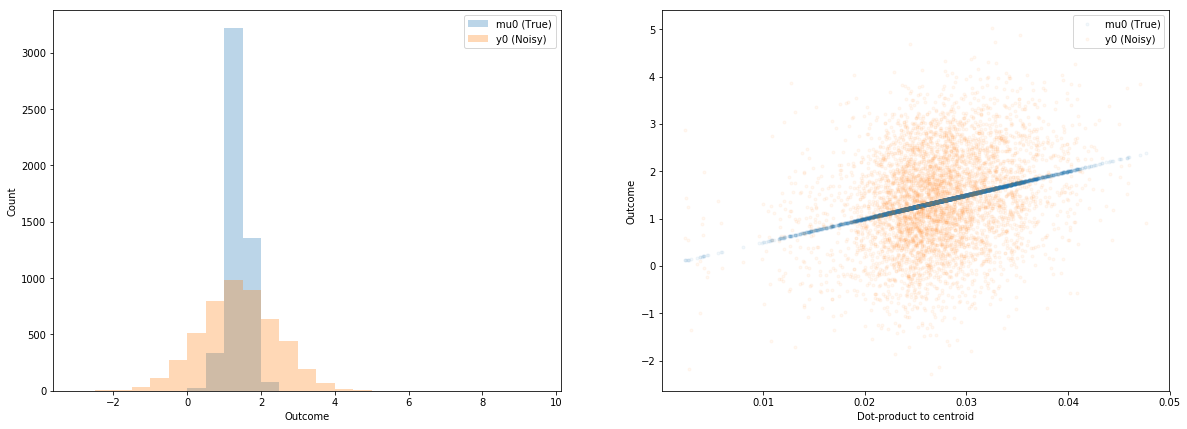

Treatment 1


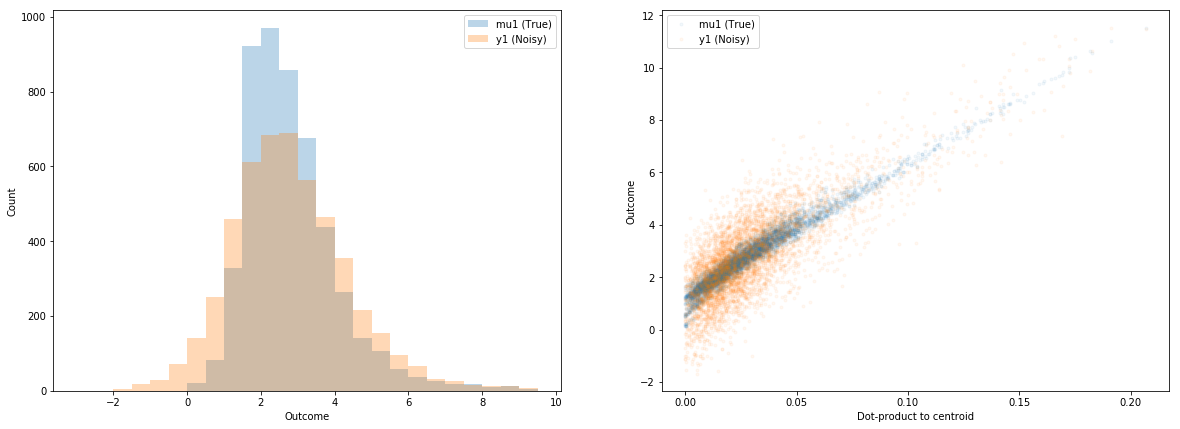

Treatment 2


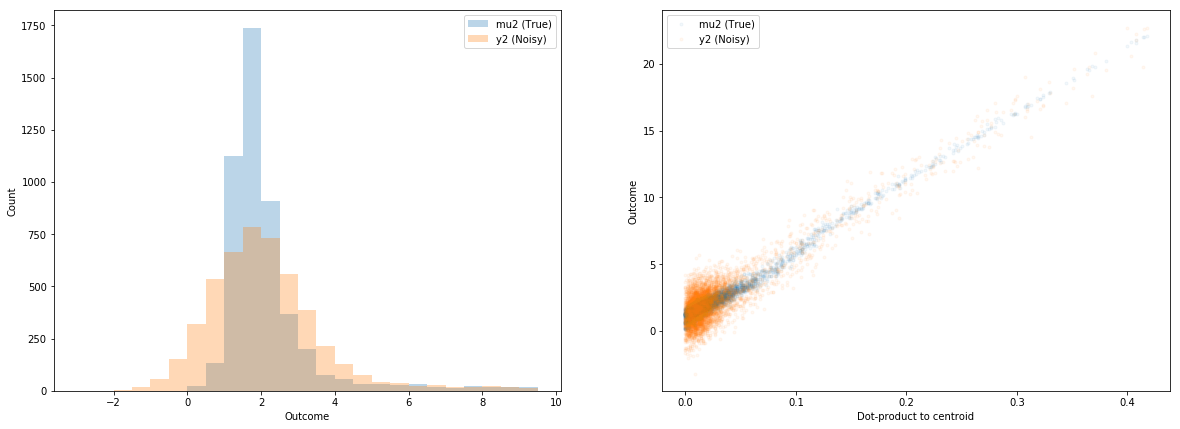

Treatment 3


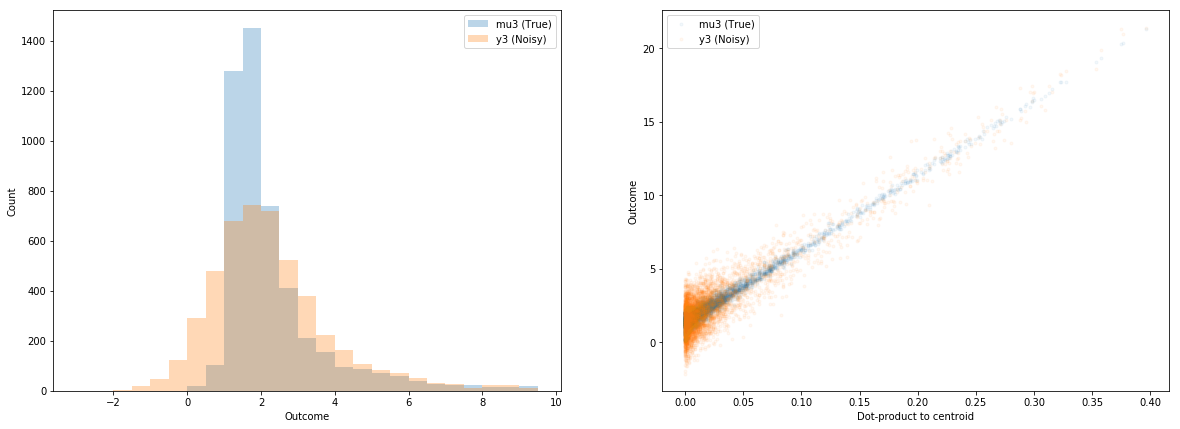

In [32]:
plt.rcParams['figure.figsize'] = (20.0, 7.0)

#s = np.clip(np.multiply((data['s']),6),0,1)
if s.size > 0:
    print("Min treatment param: "+str(min(s[:,2])))
    print("Max treatment param: "+str(max(s[:,2])))
    
    plt.subplot(121)
    plt.hist(s[:,2], bins=30, alpha=0.5, label='s')
    plt.xlabel('Treatment parameter')
    plt.ylabel('Count')

    plt.subplot(122)
    #plt.plot(dist[2], data['mu'][:,2,0], 'o', alpha=0.5)
    plt.plot(dist[2], data['s'][:,2], 'o', alpha=0.5)
    plt.xlabel('Dot-product to centroid')
    #plt.ylabel('Treatment outcome for t=2')
    plt.ylabel('Treatment parameter for t=2')
    plt.show()

for i in range(n_treatments):
    print("Treatment %d" % i)
    plt.subplot(121)
    plt.hist(data['mu'][:,i,0], bins=np.arange(-3,10,0.5), alpha=0.3, label='mu'+str(i)+" (True)")
    plt.hist(data['y'][:,i,0], bins=np.arange(-3,10,0.5), alpha=0.3, label='y'+str(i)+" (Noisy)")
    plt.xlabel('Outcome')
    plt.ylabel('Count')
    plt.legend()

    plt.subplot(122)
    plt.plot(dist[i], data['mu'][:,i,0],'o', alpha=0.05, label='mu'+str(i)+" (True)", marker='.')
    plt.plot(dist[i], data['y'][:,i,0],'o', alpha=0.05, label='y'+str(i)+" (Noisy)", marker='.')
    plt.xlabel('Dot-product to centroid')
    plt.ylabel('Outcome')
    plt.legend()


    plt.show()

#centroids = 4
dimension of centroids = 3024


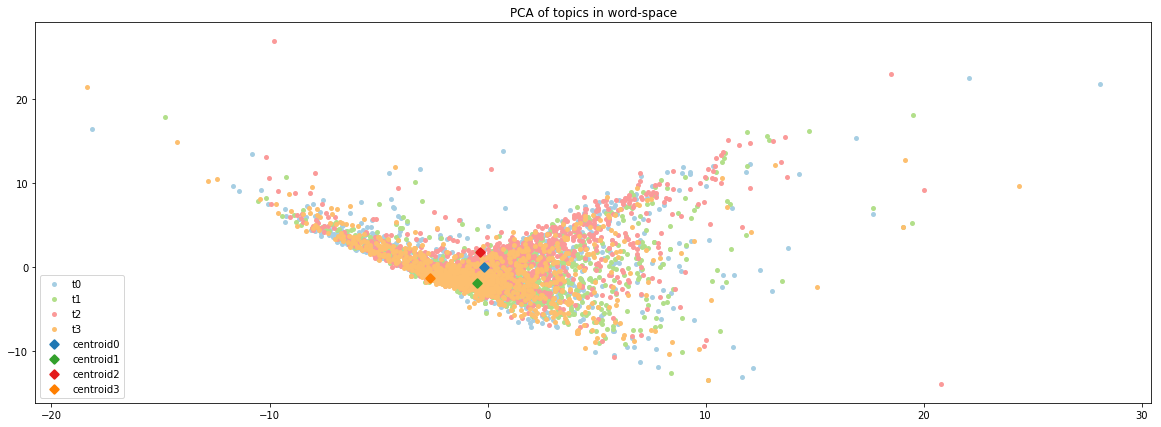

#centroids = 4
dimension of centroids = 50


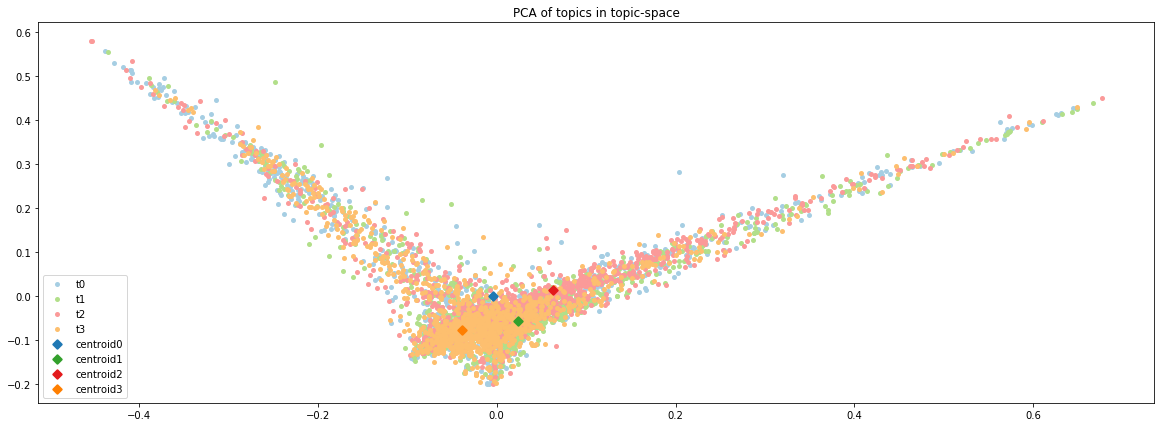

In [56]:
from sklearn.decomposition import PCA

def plot_PCA(data, centroids, space_name):
    x = data
    c_x = centroids 

    cmap_data = plt.cm.get_cmap('Paired')
    
    print("#centroids = %d" % len(c_x))
    print("dimension of centroids = %d" % len(c_x[0]))
    pca = PCA(n_components=2)
    pca = pca.fit(x)
    x_r = pca.transform(x)
    plt.figure()
    colors = [cmap_data(i*2) for i in range(n_treatments)]#['red', 'blue', 'green']

    for color, i, target_name in zip(colors, np.arange(n_treatments), ["t"+str(i) for i in range(n_treatments)]):
        plt.scatter(x_r[t == i,0], x_r[t == i,1], color=color, alpha=1, lw=2, label=target_name, marker='.')

    colors = [cmap_data(i*2+1) for i in range(n_treatments)]#['magenta', 'black', 'turquoise']
    for color, i, target_name in zip(colors, np.arange(n_treatments), ["centroid"+str(i) for i in range(n_treatments)]):
        centroid_r = pca.transform(np.array(c_x[i])[0:3024].reshape(1, -1))[0]
        plt.scatter(centroid_r[0], centroid_r[1], color=color, lw=2, label=target_name, marker='D')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of topics in ' + space_name)
    plt.show()
    
plot_PCA(data['x'][:,:,0], data['centroids_x'], "word-space")
plot_PCA(data['z'][:,:,0], c, "topic-space")